In [1]:
%matplotlib inline

## def iffie_innie(x1,y1,x2,y2,max_x, max_y)
```python
def iffie_innie(x1,y1,x2,y2,max_x, max_y):
    """ determine if the box is within the image
    """
    if x1 > 0 and y1 > 0 and x2 < max_x and y2 < max_y:
        return True
    else:
        return False
```

In [2]:
import time
nb_start_time = time.time()

import os
import tempfile
import sys

from collections import OrderedDict
import argparse

import tensorflow as tf
from tensorflow import io as tf_io

import numpy as np
import pandas as pd
import yaml

from skimage.filters import threshold_otsu
from skimage.color import rgb2lab

from PIL import ImageDraw
from PIL import TiffImagePlugin as tip

import IPython.display as ip_display

import openslide

sys.path.insert(0, '../src/python')
from digipath_toolkit import *


def im_pair_hori(im_0, im_1):
    """ Usage: new_im = im_pair_hori(im_0, im_1)
            combine a list of PIL images horizontaly
    """
    w0 = im_0.size[0]
    w = w0 + im_1.size[0] + 1
    h = max(im_0.size[1], im_1.size[1])

    new_im = tip.Image.new('RGB', (w, h) )
    box = (0, 0, w0, h)
    new_im.paste(im_0, box)
    
    box = (w0+1, 0, w, h)
    new_im.paste(im_1, box)

    return new_im

In [5]:
# a_patch = wsi_obj_0.read_region((x0, y0), image_level, patch_size)

test_data_dir = '../../DigiPath_MLTK_data/RegistrationDevData/'
os.listdir(test_data_dir)

offset_data_file = os.path.join(test_data_dir, 'wsi_pair_sample.csv')
if os.path.isfile(offset_data_file):
    offset_df = pd.read_csv(offset_data_file)
    
"""
            correctly reversed x, y
"""
offset_x = offset_df['truth_offset_x'].iloc[0]
offset_y = offset_df['truth_offset_y'].iloc[0]
offset_x, offset_y = int(round(offset_x)), int(round(offset_y))

auto_x = offset_df['auto_offset_x'].iloc[0]
auto_y = offset_df['auto_offset_y'].iloc[0]
auto_x, auto_y = int(round(auto_x)), int(round(auto_y))

# print(offset_df)
print('\noffset_x, offset_y, auto_x, auto_y\n', offset_x, offset_y, auto_x, auto_y)

fixed_wsi = os.path.join(test_data_dir, '54742d6c5d704efa8f0814456453573a.tiff')

fixed_levels_dict = get_level_sizes_dict(fixed_wsi)
fixed_max_width = fixed_levels_dict['image_size'][0]
fixed_max_height = fixed_levels_dict['image_size'][1]

print('\n\nfixed_wsi image: 54742d6c5d704efa8f0814456453573a.tiff')
for k, v in fixed_levels_dict.items():
    print('%25s: %s'%(k,v))
    
float_wsi = os.path.join(test_data_dir, 'e39a8d60a56844d695e9579bce8f0335.tiff')

float_levels_dict = get_level_sizes_dict(float_wsi)
float_max_width = float_levels_dict['image_size'][0]
float_max_height = float_levels_dict['image_size'][1]

print('\n\nfloat_wsi image: e39a8d60a56844d695e9579bce8f0335.tiff')
for k, v in float_levels_dict.items():
    print('%25s: %s'%(k,v))


offset_x, offset_y, auto_x, auto_y
 -1618 1673 -1621 1676


fixed_wsi image: 54742d6c5d704efa8f0814456453573a.tiff
               image_size: (145408, 83968)
              level_count: 10
        level_downsamples: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)
         level_diminsions: ((145408, 83968), (72704, 41984), (36352, 20992), (18176, 10496), (9088, 5248), (4544, 2624), (2272, 1312), (1136, 656), (568, 328), (284, 164))


float_wsi image: e39a8d60a56844d695e9579bce8f0335.tiff
               image_size: (126976, 75776)
              level_count: 9
        level_downsamples: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0)
         level_diminsions: ((126976, 75776), (63488, 37888), (31744, 18944), (15872, 9472), (7936, 4736), (3968, 2368), (1984, 1184), (992, 592), (496, 296))


In [54]:
wsi_obj_0.close()

In [55]:
run_parameters = {'wsi_filename': fixed_wsi, 
                  'wsi_floatname': float_wsi,
                  'thumbnail_divisor': 20, 
                  'patch_select_method': 'threshold_rgb2lab', 
                  'rgb2lab_threshold': 80, 
                  'image_level': 0, 
                  'patch_height': 224, 
                  'patch_width': 224, 
                  'threshold': 0, 
                  'offset_x': offset_x, 
                  'offset_y': offset_y}

patch_igetor = PatchImageGenerator(run_parameters)
wsi_obj_0 = openslide.OpenSlide(run_parameters['wsi_floatname'])

fixed_x: 27344 float_x: 25726	fixed_y: 96 float_y: 1769


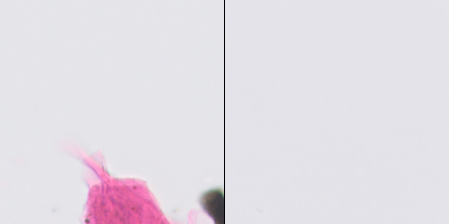

In [58]:
# nptch_dict = patch_igetor.next_patch()
fxd_im = nptch_dict['patch_image']

image_level = run_parameters['image_level']
patch_size = (run_parameters['patch_width'], run_parameters['patch_height'])

x0 = nptch_dict['level_0_x'] + run_parameters['offset_x']
y0 = nptch_dict['level_0_y'] + run_parameters['offset_y']
flot_im = wsi_obj_0.read_region((x0, y0), image_level, patch_size)

print('fixed_x: %i float_x: %i\tfixed_y: %i float_y: %i'%(nptch_dict['level_0_x'],x0,nptch_dict['level_0_y'],y0))
display(im_pair_hori(fxd_im, flot_im))